# Initialization


## Import libraries


In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from pyprojroot import here
import seaborn as sns
import networkx as nx
import random
from ast import literal_eval
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

from src.preproc.utils import run_code

# Import utility functions for analysis
from src.analysis.analysis_utils import *
from src.analysis.gini_analysis import *

# set up numpy rng
rng = np.random.default_rng(seed=1)
random.seed(1)

## Constants


We will first define constants, including the name of the experiment, the main model whose code we will use, the names of the models we will compare for inter-rater reliability, and theming for the plots.


In [2]:
EXPERIMENT_NAME = "full-experiment"
CODER_MODEL = "claude-3-5-sonnet-20241022"
CODER_MODEL_NAME = "Claude 3.5 Sonnet"

COLOR_DARKER = "#2b4162"
COLOR_DARK = "#7995c1"
COLOR_LIGHT = "#c1c5c9"
GREY = "#e6e6e6"

BLUE_GRADIENT = ["#a9c2eb", COLOR_DARK, "#516c96", COLOR_DARKER]
RED_GRADIENT = ["#e89797", "#b06666", "#914a46", "#632f2f"]
GREEN_GRADIENT = ["#7fcdbb", "#50a692", "#1d7d67"]
CATEGORICAL_COLORS = [COLOR_DARKER, COLOR_DARK, "#d0d1e6", "#e6e6e6"]


SMALL_PANEL_WIDTH = 2.2 * 3
SMALL_PANEL_HEIGHT = 2 * 3

GRAPH_COLORS = {
    "edge": "#2F4858",  # Dark blue/grey for forward transitions
    "incorrect": "#d13636",  # Orange for incorrect transitions
    "node_fill": "#2F4858",  # Very light grey for node fill
    "node_border": "#2F4858",  # node border color
    "subgoal_fill": "#7fcdbb",  # subgoal color for minimalistic style
    "subgoal_border": "#7fcdbb",  # subgoal color for minimalistic style
    "start_state_border": "#d0d1e6",  # start state color for minimalistic style
    "start_state_fill": "#d0d1e6",  # start state color for minimalistic style
    "target_border": "#67a9cf",  # target color for minimalistic style
    "target_fill": "#67a9cf",  # Medium purple for target border
}

GGPLOT_THEME = theme_light() + theme(
    panel_background=element_rect(fill="white"),
    plot_background=element_rect(fill="white"),
    panel_grid_major_x=element_blank(),
    panel_grid_minor_x=element_blank(),
    text=element_text(family="Avenir"),
    axis_text=element_text(family="Avenir", color="black"),
    panel_grid_minor_y=element_blank(),
    panel_grid_major_y=element_line(color="#cccccc", size=0.3),
)

RATERS = {
    "claude-3-5-sonnet-20241022": "Claude 3.5 Sonnet",
    "llama-v3p1-8b-instruct": "Llama 3.1 8B",
    "llama-v3p3-70b-instruct": "Llama 3.3 70B",
    "deepseek-v3-0324": "DeepSeek V3",
    "llama4-maverick-instruct-basic": "Llama 4 Maverick",
    "llama4-scout-instruct-basic": "Llama 4 Scout",
    "qwen3-235b-a22b": "Qwen 3 235B",
    "human": "Human",
}

## Read data


Next, we will read the preprocessed experimental data.


In [3]:
# data from main experiment
## all data
df_full_raw = pd.read_csv(
    here(f"data/processed/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}-full.csv")
)
## just 24 game trials data
df_trials_raw = pd.read_csv(
    here(f"data/processed/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}-trials.csv")
)
# data coded with main coder model
df_coded_raw = pd.read_csv(
    here(
        f"data/featurized/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_model-{CODER_MODEL}-featurized.csv"
    )
)
# data from control experiment
## all data
df_full_control_raw = pd.read_csv(
    here(f"data/processed/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}-control-full.csv")
)
## just 24 game trials data
df_trials_control_raw = pd.read_csv(
    here(f"data/processed/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}-control-trials.csv")
)

# read in precomputed IRR data
irr_raw_filepath = here("data/coded/irr/irr_results.csv")
df_irr = pd.read_csv(irr_raw_filepath)


# read in error analysis data
df_coder_errors = pd.read_csv(here("data/analysis/full-experiment-errors.csv"))

# read in list of problems
df_problem_set = pd.read_csv(here(f"data/problem-set/problem_set.csv"))

## Process data


Next we process exclusions. That is, we remove practice trials, trials where the starting numbers were the same as the practice trial, and trials where the participant said nothing relevant to the task.


In [4]:
####################################
# process main experiment data
####################################

# exclude participants with 5 or below relevant transcripts
participants_to_exclude = (
    df_trials_raw.copy()
    # remove practice trials
    .query("not practice")
    # calculate percentage of relevant trials per participants
    .assign(
        relevant_ratio=lambda df: df.groupby("pid")["relevant"].transform("mean"),
    )
    # find participants with 0.5 or below relevant ratio
    .query("relevant_ratio <= 0.5")
    # get unique participant ids
    .pid.unique()
)

## process 24 game trials data
df_trials_proc = (
    df_trials_raw.copy()
    # remove practice
    .query("not practice")
    # remove trials from a single condition that had the same problem that was included as practice
    .query("choices != '[1,1,2,6]'")
    # calculate trial index
    .assign(
        trial_index=lambda df: df.groupby("pid").cumcount() + 1,
    )
    # remove irrelevant trials
    .query("relevant == 1")
    # exclude participants in exclusion list
    .query("pid not in @participants_to_exclude")
    # trials that went over 3 minutes and one second due to lag must be set to 0.0 and the response column set to nan
    .assign(
        correct=lambda df: df["correct"]
        .where(cond=df["rt_s"] <= 181, other=0.0)
        .astype(float)
    )
    .assign(
        response=lambda df: df["response"].where(cond=df["rt_s"] <= 181, other=np.nan)
    )
    .assign(rt_s=lambda df: df["rt_s"].clip(upper=180))
    # calculate transcript length
    .assign(transcript_length=lambda df: df["transcript"].str.count(r"\w+"))
    # reset index
    .reset_index(drop=True)
)

## process trials from groups 2,7,16 - which will be compared behaviorally with control group and thus no exclusions will be applied
df_trials_3conditions_noExclusions_proc = (
    df_trials_raw.copy()
    # remove practice effect
    .query("not practice")
    # only keep participants in conditions 2,7,16
    .query("condition in [2,7,16]")
    # trials that went over 3 minutes and one second due to lag must be set to 0.0 and the response column set to nan
    .assign(
        correct=lambda df: df["correct"]
        .where(cond=df["rt_s"] <= 181, other=0.0)
        .astype(float)
    )
    .assign(
        response=lambda df: df["response"].where(cond=df["rt_s"] <= 181, other=np.nan)
    )
    .assign(rt_s=lambda df: df["rt_s"].clip(upper=180))
    # reset index
    .reset_index(drop=True)
)

# process data coded by coder models
df_coded_proc = (
    df_coded_raw.copy()
    # remove practice trials
    .query("not practice")
    # remove trials from a single condition that had the same problem that was included as practice
    .query("choices != '[1,1,2,6]'")
    # calculate trial index
    .assign(
        trial_index=lambda df: df.groupby("pid").cumcount() + 1,
    )
    # remove participants in exclusion list
    .query("pid not in @participants_to_exclude")
    # remove irrelevant trials
    .query("relevant == 1")
    # trials that went over 3 minutes and one second due to lag must be set to 0.0 and the response column set to nan
    .assign(
        correct=lambda df: df["correct"]
        .where(cond=df["rt_s"] <= 181, other=0.0)
        .astype(float)
    )
    .assign(
        response=lambda df: df["response"].where(cond=df["rt_s"] <= 181, other=np.nan)
    )
    .assign(rt_s=lambda df: df["rt_s"].clip(upper=180))
    # reset index
    .reset_index(drop=True)
)
# run code for each graph and save the graphs to the dataframe
graphs = [
    run_code(code_translation, for_pretraining=False)
    for code_translation in tqdm(df_coded_proc["lm_code_translation"])
]
df_coded_proc["graph"] = graphs

####################################
# process control experiment data
####################################

df_trials_control_proc = (
    df_trials_control_raw.copy()
    # remove practice
    .query("not practice")
    # convert correctness to float
    .assign(correct=lambda df: df["correct"].astype(float))
    # clip response time
    .assign(rt_s=lambda df: df["rt_s"].clip(upper=180))
    # reset index
    .reset_index(drop=True)
)

####################################
# Process irr data
####################################

df_irr_proc = (
    df_irr.copy()
    # get graphs from code translation
    .assign(
        lm_graph=lambda df: df.apply(
            lambda x: (
                run_code(x["lm_code_translation"], for_pretraining=False)
                if type(x["lm_code_translation"]) == str
                else np.nan
            ),
            axis=1,
        ),
        ben_graph=lambda df: df.apply(
            lambda x: (
                run_code(x["ben_annotation"], for_pretraining=False)
                if type(x["ben_annotation"]) == str
                else np.nan
            ),
            axis=1,
        ),
        ced_graph=lambda df: df.apply(
            lambda x: (
                run_code(x["ced_annotation"], for_pretraining=False)
                if type(x["ced_annotation"]) == str
                else np.nan
            ),
            axis=1,
        ),
    )
    # calculate normalized edit distance
    .assign(
        norm_ged_human1_model=lambda df: df.apply(
            lambda x: (
                compute_normalized_ged(
                    x["ben_model_ged"], x["ben_graph"], x["lm_graph"]
                )
                if x["model"] != "human"
                else np.nan
            ),
            axis=1,
        ),
        norm_ged_human2_model=lambda df: df.apply(
            lambda x: (
                compute_normalized_ged(
                    x["ced_model_ged"], x["ced_graph"], x["lm_graph"]
                )
                if x["model"] != "human"
                else np.nan
            ),
            axis=1,
        ),
        norm_ged_human_human=lambda df: df.apply(
            lambda x: (
                compute_normalized_ged(x["human_ged"], x["ben_graph"], x["ced_graph"])
                if x["model"] == "human"
                else np.nan
            ),
            axis=1,
        ),
    ).assign(
        avg_edit_distance=lambda df: df.apply(
            lambda x: (
                (x["norm_ged_human1_model"] + x["norm_ged_human2_model"]) / 2
                if np.isnan(
                    x["norm_ged_human_human"]
                )  # if this is a model-human comparison
                else x["norm_ged_human_human"]  # if this is a human-human comparison
            ),
            axis=1,
        )
    )
    # convert model name to human readable names
    .assign(model=lambda df: df["model"].map(RATERS))
)

####################################
# Process error analysis data
####################################

PROBLEM_TYPES = {
    "runnability_errors": "Invalid Operation",
    "state_calculation_errors": "Calculation Error",
    "failed_to_run": "Code Failed to Run",
}


df_coder_errors_proc = (
    df_coder_errors[
        ["runnability_errors", "state_calculation_errors", "failed_to_run", "model"]
    ]
    .assign(
        model=lambda df: df["model"].map(RATERS),
        failed_to_run=lambda df: df["failed_to_run"].astype(int),
    )
    # pivot the data to long format
    .melt(
        id_vars=["model"],
        value_vars=[
            "runnability_errors",
            "state_calculation_errors",
            "failed_to_run",
        ],
        var_name="problem_type",
        value_name="count",
    )
    .assign(
        problem_type=lambda df: df["problem_type"].map(PROBLEM_TYPES),
    )
)

100%|██████████| 4947/4947 [00:02<00:00, 2164.01it/s]


# Analysis


## Exploratory data visualizations


### Accuracy by problem


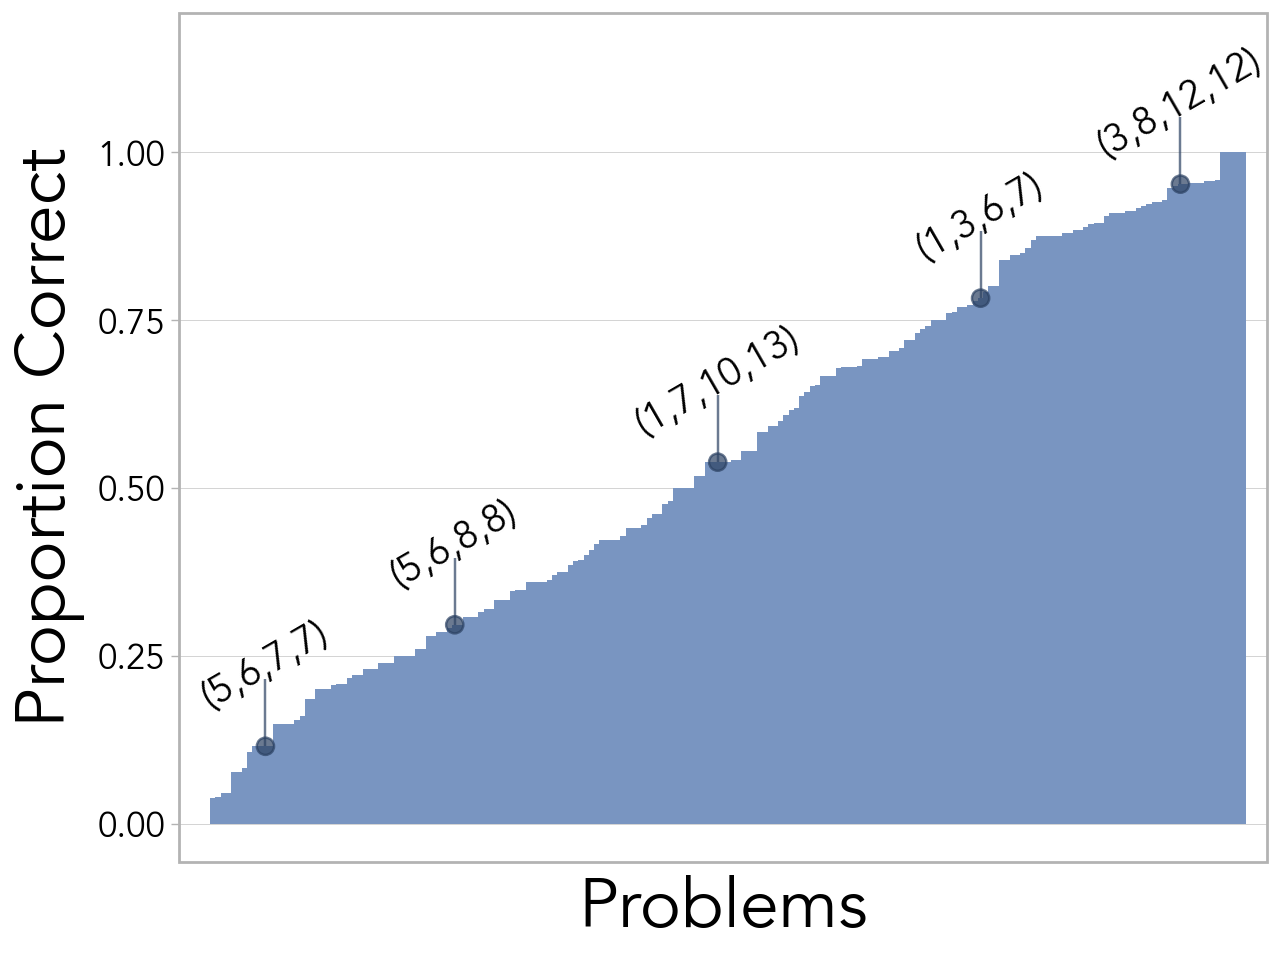

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.6000000000000005 x 6 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/problem_accuracy_bar.png


In [5]:
# Get the data sorted by accuracy and add an index column
problem_stats = (
    df_trials_proc.groupby(["choices"])
    .agg({"correct": "mean"})
    .reset_index()
    .sort_values("correct", ascending=True)
    .assign(
        choices=lambda df: df["choices"].apply(
            lambda x: x.replace("[", "(").replace("]", ")")
        )
    )
)  # Sort in ascending order

# Select more spread out problems to annotate
n_problems = len(problem_stats)
problems_to_annotate = pd.concat(
    [
        problem_stats.iloc[-13:-12],
        problem_stats.iloc[
            3 * n_problems // 4 - 1 : 3 * n_problems // 4
        ],  # 75th percentile
        problem_stats.iloc[n_problems // 2 - 1 : n_problems // 2],  # 50th percentile
        problem_stats.iloc[n_problems // 4 - 1 : n_problems // 4],  # 25th percentile
        problem_stats.iloc[12:13],
    ]
)

# Create the plot with a single fill color
problem_accuracy_bar = (
    ggplot(problem_stats, aes(x="reorder(choices, correct)", y="correct"))
    # Set a fixed fill color for all bars
    + geom_bar(stat="identity", width=1, fill=COLOR_DARK, color=None)
    # Simplified annotation points - smaller and more subtle
    + geom_point(
        data=problems_to_annotate,
        mapping=aes(x="choices"),
        color=COLOR_DARKER,
        size=3,
        alpha=0.7,
    )
    # Thinner annotation lines
    + geom_segment(
        data=problems_to_annotate,
        mapping=aes(x="choices", xend="choices", y="correct", yend="correct + 0.1"),
        color=COLOR_DARKER,
        size=0.5,
        alpha=0.7,
    )
    + geom_text(
        data=problems_to_annotate,
        mapping=aes(x="choices", y="correct + 0.12", label="choices"),
        angle=30,
        size=14,
        family="Avenir",
    )
    + labs(x="Problems", y="Proportion Correct")
    + scale_y_continuous(limits=[0, 1.15], breaks=[0, 0.25, 0.5, 0.75, 1.0])
    + scale_x_discrete(expand=(0.02, 0.02))
    + GGPLOT_THEME
    + theme(
        axis_title_x=element_text(size=25),  # Adjust the size as needed
        axis_title_y=element_text(size=25),
        axis_text_x=element_blank(),
        axis_ticks_x=element_blank(),
        axis_text_y=element_text(size=12.5),
        legend_position="none",
    )
)

problem_accuracy_bar.show()
problem_accuracy_bar.save(
    here("figures/problem_accuracy_bar.png"),
    dpi=2000,
    width=SMALL_PANEL_WIDTH,
    height=SMALL_PANEL_HEIGHT,
)

Here, we will make a few more visualizations, like the histogram of number of correct trials per participant.


## 0. Validity of talk-aloud method with LMs

This section of the notebook contains the analyses designed to assess the validity of our methods. It computes inter-rater reliability between human raters and between humans and language models. It also includes performance-level comparisons between the talk-aloud and no talk-aloud conditions.


### Inter-rater reliability


We compare the different coders using a paired permutation test.


/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/scales/scale_manual.py:39: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 4 values. 8 were requested from it.


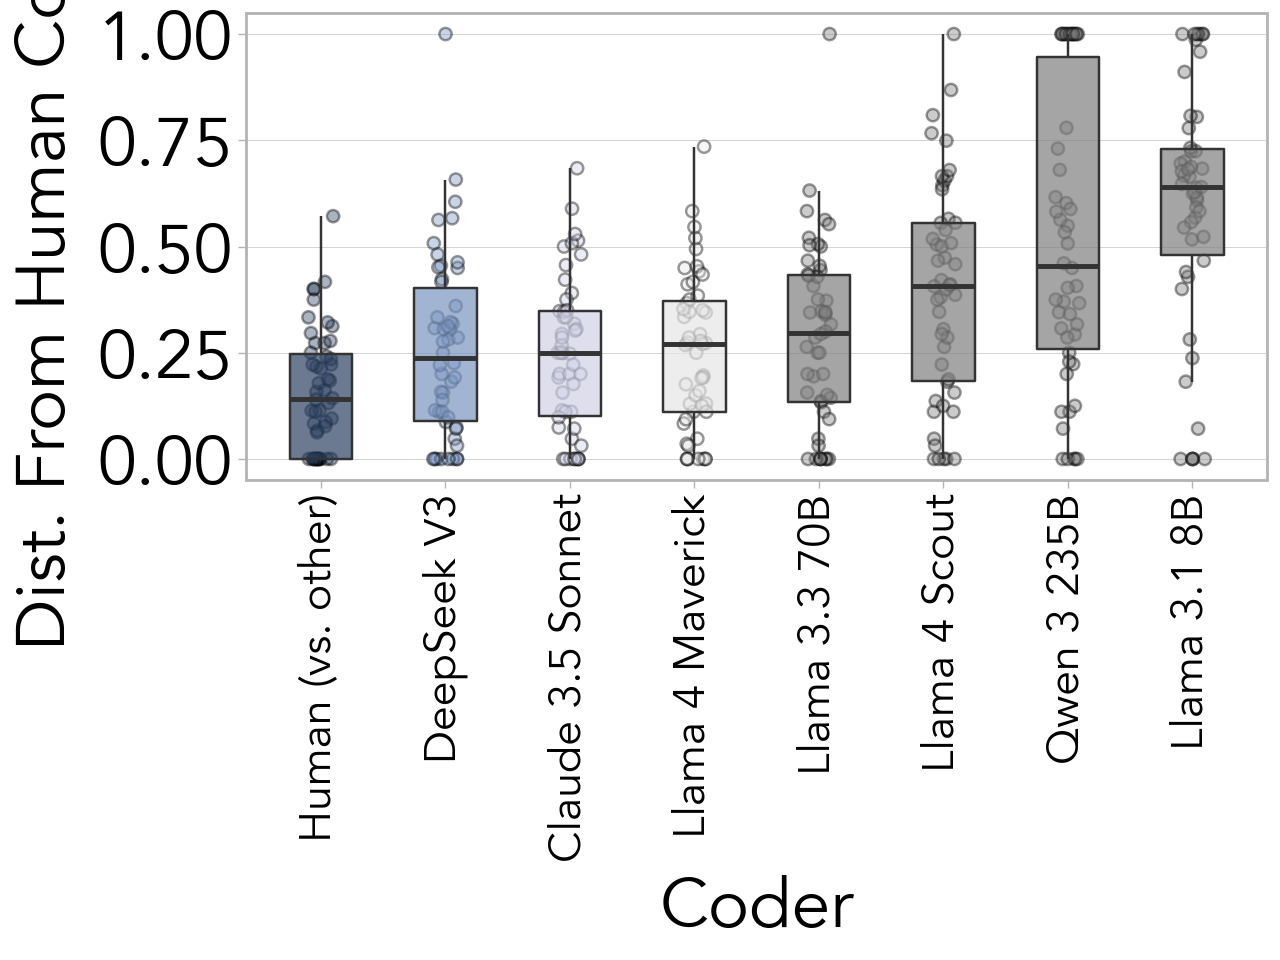

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 9.600000000000001 x 6 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/inter_rater_reliability.png
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/scales/scale_manual.py:39: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 4 values. 8 were requested from it.


In [6]:
# box plot of edit distance between raters and model and between raters
median_edit_distance = (
    df_irr_proc.groupby("model")["avg_edit_distance"].median().sort_values()
)

df_irr_plot = (
    df_irr_proc.copy()
    .assign(
        model=pd.Categorical(
            df_irr_proc.model,
            categories=median_edit_distance.index,
        )
    )
    .assign(
        model=lambda df: df.model.map(
            lambda x: "Human (vs. other)" if x == "Human" else x
        )
    )
)


# Create the box plot with overlaid points
plot = (
    ggplot(df_irr_plot, aes(x="model", y="avg_edit_distance", fill="model"))
    + geom_point(
        position=position_jitter(width=0.1, height=0.0), alpha=0.4, size=2
    )  # Add jittered points
    + geom_boxplot(alpha=0.7, outlier_shape="", width=0.5)  # Hide default outliers
    + GGPLOT_THEME
    + labs(
        x="Coder",
        y="Dist. From Human Coders",
    )
    # set colors
    + scale_fill_manual(values=CATEGORICAL_COLORS)
    + theme(legend_position="none", text=element_text(size=25))
    # set size of axis labels
    + theme(axis_text_x=element_text(size=16, angle=90))
)

plt.tight_layout()
plot.show()
plot.save(
    here("figures/inter_rater_reliability.png"),
    width=SMALL_PANEL_WIDTH + 3,
    height=SMALL_PANEL_HEIGHT,
    dpi=2000,
)

In [7]:
print("Model-Human vs. Human-Human:\n")
for model in list(RATERS.values())[:-1]:
    print(f"model: {model}")
    print(
        f"mean edit distance: {df_irr_proc.query('model == @model')['avg_edit_distance'].mean()}"
    )
    model_edit_distances = df_irr_proc.query("model == @model")[
        "avg_edit_distance"
    ].to_numpy()
    human_edit_distances = df_irr_proc.query("model == 'Human'")[
        "avg_edit_distance"
    ].to_numpy()

    res = stats.permutation_test(
        (model_edit_distances, human_edit_distances),
        statistic=lambda x, y, axis: np.mean(x, axis=axis) - np.mean(y, axis=axis),
        vectorized=True,
        n_resamples=100_000,
        permutation_type="samples",
        random_state=rng,
    )
    print(f"{model}-human vs. human-human: {res.statistic:.4f} (p={res.pvalue:.4f})\n")

print("Model vs. Model:\n")
for i, model1 in enumerate(list(RATERS.values())[:-1]):
    model1_edit_distances = df_irr_proc.query(f"model == @model1")[
        "avg_edit_distance"
    ].to_numpy()
    for j, model2 in enumerate(list(RATERS.values())[:-1]):
        model2_edit_distances = df_irr_proc.query(f"model == @model2")[
            "avg_edit_distance"
        ].to_numpy()
        if j >= i:
            continue
        res = stats.permutation_test(
            (model1_edit_distances, model2_edit_distances),
            statistic=lambda x, y, axis: np.mean(x, axis=axis) - np.mean(y, axis=axis),
            vectorized=True,
            n_resamples=100_000,
            permutation_type="samples",
            random_state=rng,
        )
        print(f"{model1} vs {model2}: {res.statistic:.4f} (p={res.pvalue:.4f})\n")

Model-Human vs. Human-Human:

model: Claude 3.5 Sonnet
mean edit distance: 0.2437414977258231
Claude 3.5 Sonnet-human vs. human-human: 0.0848 (p=0.0008)

model: Llama 3.1 8B
mean edit distance: 0.5935521082097072
Llama 3.1 8B-human vs. human-human: 0.4346 (p=0.0000)

model: Llama 3.3 70B
mean edit distance: 0.2891170103701666
Llama 3.3 70B-human vs. human-human: 0.1302 (p=0.0001)

model: DeepSeek V3
mean edit distance: 0.25832390904578395
DeepSeek V3-human vs. human-human: 0.0994 (p=0.0018)

model: Llama 4 Maverick
mean edit distance: 0.24991576842594784
Llama 4 Maverick-human vs. human-human: 0.0910 (p=0.0003)

model: Llama 4 Scout
mean edit distance: 0.3955340780066321
Llama 4 Scout-human vs. human-human: 0.2366 (p=0.0000)

model: Qwen 3 235B
mean edit distance: 0.5154587098171234
Qwen 3 235B-human vs. human-human: 0.3565 (p=0.0000)

Model vs. Model:

Llama 3.1 8B vs Claude 3.5 Sonnet: 0.3498 (p=0.0000)

Llama 3.3 70B vs Claude 3.5 Sonnet: 0.0454 (p=0.0338)

Llama 3.3 70B vs Llama 3.

Now we'll visualize a few graphs with high and low edit distance between humans and Claude


100%|██████████| 50/50 [00:00<00:00, 2029.70it/s]

low edit distance: 0.047619047619047616


<Figure size 640x480 with 0 Axes>

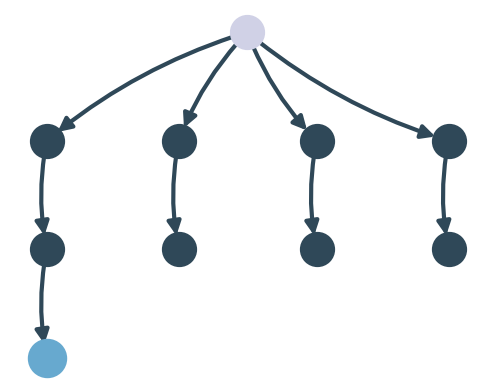

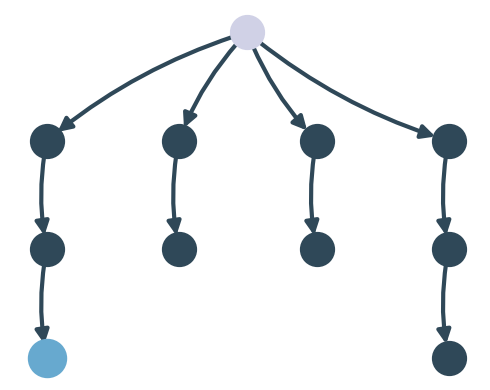

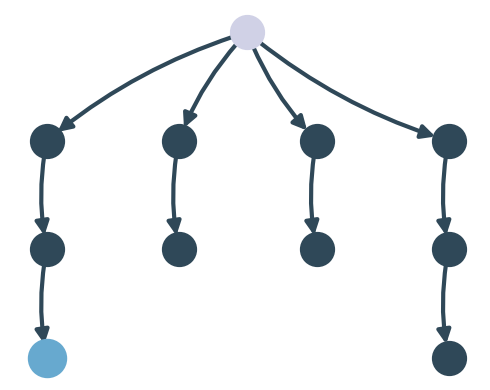

high edit distance: 0.5138528138528138


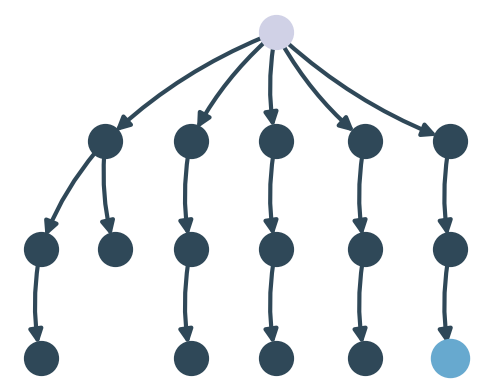

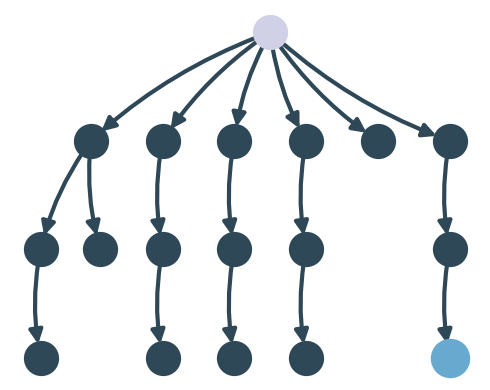

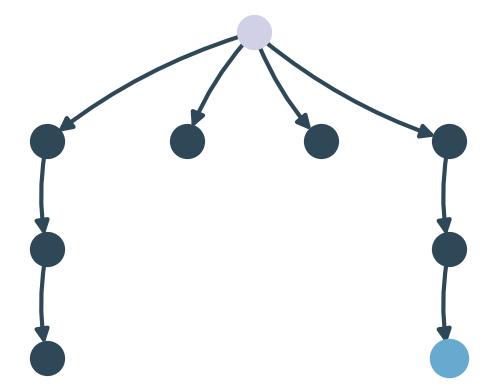

In [8]:
# sort by edit distance from coder model (Claude 3.5 Sonnet)
df_agreement = (
    df_irr_proc.query("model == @CODER_MODEL_NAME")
    .sort_values(by="avg_edit_distance", ascending=True)
    .reset_index(drop=True)
)


# create a column for lm_graph and human_graph
lm_graphs = [
    run_code(code_translation, for_pretraining=False)
    for code_translation in tqdm(df_agreement["lm_code_translation"])
]

coder_1_graphs = [
    run_code(code_translation, for_pretraining=False)
    for code_translation in tqdm(df_agreement["ben_annotation"])
]

coder_2_graphs = [
    run_code(code_translation, for_pretraining=False)
    for code_translation in tqdm(df_agreement["ced_annotation"])
]


for idx, edit_distance in zip([9, 46], ["low", "high"]):

    graph_1 = coder_1_graphs[idx]
    graph_2 = coder_2_graphs[idx]
    graph_model = lm_graphs[idx]
    print(f"{edit_distance} edit distance:", df_agreement["avg_edit_distance"][idx])

    colors = {
        "edge": "#2F4858",  # Dark blue/grey for forward transitions
        "incorrect": "#d13636",  # Orange for incorrect transitions
        "node_fill": "#2F4858",  # Very light grey for node fill
        "subgoal_border": "#a6bddb",  # Sky blue for subgoal border
        "subgoal_fill": "#a6bddb",  # subgoal color for minimalistic style
        "start_state_border": "#d0d1e6",  # start state color for minimalistic style
        "start_state_fill": "#d0d1e6",  # start state color for minimalistic style
        "target_border": "#67a9cf",  # target color for minimalistic style
        "target_fill": "#67a9cf",  # Medium purple for target border
        "node_border": "#2F4858",  # node border color for minimalistic style
    }

    edge_vis_dict = {
        "arrowstyle": "-|>",
        "arrowsize": 20,
        "min_source_margin": 10,
        "min_target_margin": 10,
    }

    fig, ax = graph_1.draw_graph(
        mode="minimal",
        colors=colors,
        node_size=500,
        figsize=(5, 4),
        fontsize_node_labels=8,
        edge_vis_dict=edge_vis_dict,
    )

    plt.tight_layout()
    plt.show()
    fig.savefig(here(f"figures/{edit_distance}_edit_distance_example_rater_1.svg"))
    plt.close()

    fig, ax = graph_2.draw_graph(
        mode="minimal",
        colors=colors,
        node_size=500,
        figsize=(5, 4),
        fontsize_node_labels=8,
        edge_vis_dict=edge_vis_dict,
    )

    plt.tight_layout()
    plt.show()
    fig.savefig(here(f"figures/{edit_distance}_edit_distance_example_rater_2.svg"))
    plt.close()

    fig, ax = graph_model.draw_graph(
        mode="minimal",
        colors=colors,
        node_size=500,
        figsize=(5, 4),
        fontsize_node_labels=8,
        edge_vis_dict=edge_vis_dict,
    )

    plt.tight_layout()
    plt.show()
    fig.savefig(here(f"figures/{edit_distance}_edit_distance_example_claude.svg"))
    plt.close()

### Split-half correlation analysis

We compute the trial-level correlations between participants in the think-aloud condition and the no think-aloud condition for three problem groups, and compare these correlations to the split-half correlation for the same problem groups in the no think-aloud condition.

We make this comparison using bootstrapping. Since there were more participants in the think-aloud condition than the no think-aloud condition, it is possible that the split half correlations are higher simply by law of large numbers. To account for this, each iteration of bootstrapping uses only 30 participants' data, to match the amount of data we have in the no think-aloud condition.


In [9]:
num_samples = 10_000
condition_dfs_vp = {}
condition_dfs_novp = {}
comparison_conditions = df_trials_3conditions_noExclusions_proc["CONDITION"].unique()
for condition in comparison_conditions:
    df_cond_vp = df_trials_3conditions_noExclusions_proc.query(
        "CONDITION == @condition"
    )
    condition_dfs_vp[condition] = df_cond_vp
    df_cond_novp = df_trials_control_proc.query("CONDITION == @condition")
    condition_dfs_novp[condition] = df_cond_novp

n_pps_per_group = 10

# compute within correlations
correlations_within_vp = []
for _ in tqdm(range(num_samples)):
    pids1, pids2 = [], []
    for condition in comparison_conditions:
        df_cond = condition_dfs_vp[condition]
        pids = df_cond["pid"].unique()
        chosen_pids = rng.choice(pids, size=2 * n_pps_per_group, replace=False)
        pids1.extend(chosen_pids[:n_pps_per_group])
        pids2.extend(chosen_pids[n_pps_per_group:])

    # sample num_participants_per_sample from each array
    df_vp_sample1 = df_trials_3conditions_noExclusions_proc.query("pid in @pids1")
    df_vp_sample2 = df_trials_3conditions_noExclusions_proc.query("pid in @pids2")
    # get trials df for each participant group
    correlation = compute_item_correlation(df_vp_sample1, df_vp_sample2)
    correlations_within_vp.append(correlation)

correlations_within_vp = np.array(correlations_within_vp)

# compute between correlations
correlations_between_groups = []
for _ in tqdm(range(num_samples)):
    # sample num_participants_per_sample from each array
    pids_vp, pids_novp = [], []
    for condition in comparison_conditions:
        df_cond_vp = condition_dfs_vp[condition]
        df_cond_novp = condition_dfs_novp[condition]
        pids_vp.extend(df_cond_vp["pid"].sample(n_pps_per_group, replace=False))
        pids_novp.extend(df_cond_novp["pid"].sample(n_pps_per_group, replace=False))

    # get trials df for each participant group
    df_vp_sample = df_trials_3conditions_noExclusions_proc.copy().query(
        "pid in @pids_vp"
    )
    df_novp_sample = df_trials_control_proc.copy().query("pid in @pids_novp")
    correlation = compute_item_correlation(df_vp_sample, df_novp_sample)
    correlations_between_groups.append(correlation)

correlations_between_groups = np.array(correlations_between_groups)

100%|██████████| 10000/10000 [00:39<00:00, 255.10it/s]


In [10]:
# Compute the proportion of times within-group correlation is greater than between-group
proportion_greater = np.mean(correlations_within_vp > correlations_between_groups)

# Calculate means
mean_within = np.mean(correlations_within_vp)
mean_between = np.mean(correlations_between_groups)

# get a null distribution
mean_diff = mean_between - mean_within
diffs = correlations_within_vp - correlations_between_groups
null_distribution = diffs - mean_diff

# null_distribution = correlations_within_vp - mean_within
p_value = (np.abs(mean_diff) <= np.abs(null_distribution)).mean()

# Print results
print(f"Mean within-VP correlation: {mean_within:.2f}")
print(f"Mean between-groups correlation: {mean_between:.2f}")
print(f"Proportion of times within > between: {proportion_greater:.3f}")
print(f"mean_diff: {mean_diff:.3f}")
print(f"Permutation test p-value: {p_value:.3f}")

Mean within-VP correlation: 0.83
Mean between-groups correlation: 0.79
Proportion of times within > between: 0.659
mean_diff: -0.035
Permutation test p-value: 0.743


#### Accuracy and response time comparison


In [11]:
df_comp_vp = df_trials_3conditions_noExclusions_proc[["choices", "correct", "rt_s"]]
df_comp_vp["condition"] = "VP"

df_comp_novp = df_trials_control_proc[["choices", "correct", "rt_s"]]
df_comp_novp["condition"] = "noVP"

df_comps = pd.concat([df_comp_vp, df_comp_novp])

print(
    f"mean accuracy in VP: {df_comp_vp['correct'].mean()}, no VP: {df_comp_novp['correct'].mean()}"
)
stat, p_value = within_problem_permutation_test(df_comps, rng, dep_var="correct")
print(f"diff: {stat}, p-value: {p_value}")
print(
    f"mean response time in VP: {df_comp_vp['rt_s'].mean()}, no VP: {df_comp_novp['rt_s'].mean()}"
)
stat, p_value = within_problem_permutation_test(df_comps, rng, dep_var="rt_s")
print(f"diff: {stat}, p-value: {p_value}")

/var/folders/j2/m8twlxj12xdg_b0wm25qx_x40000gn/T/ipykernel_40107/641868307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/j2/m8twlxj12xdg_b0wm25qx_x40000gn/T/ipykernel_40107/641868307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean accuracy in VP: 0.4875, no VP: 0.5283333333333333


100%|██████████| 10000/10000 [00:46<00:00, 216.78it/s]


diff: 0.04083333333333333, p-value: 0.0669
mean response time in VP: 125.06770833333333, no VP: 117.66333333333333


100%|██████████| 10000/10000 [00:46<00:00, 216.56it/s]

diff: -7.404375000000002, p-value: 0.0083


Response time correlation


In [12]:
mean_rt_vp = df_trials_3conditions_noExclusions_proc.groupby(["choices"])["rt_s"].mean()

mean_rt_novp = df_trials_control_proc.groupby(["choices"])["rt_s"].mean()

rt_corr = stats.pearsonr(mean_rt_vp, mean_rt_novp)
print(f"rt correlation across conditions: {rt_corr.statistic}, p={rt_corr.pvalue}")

rt correlation across conditions: 0.9478671084113726, p=1.947648318916087e-15


### Coder Error analysis

We want to characterize the errors made by the coders.


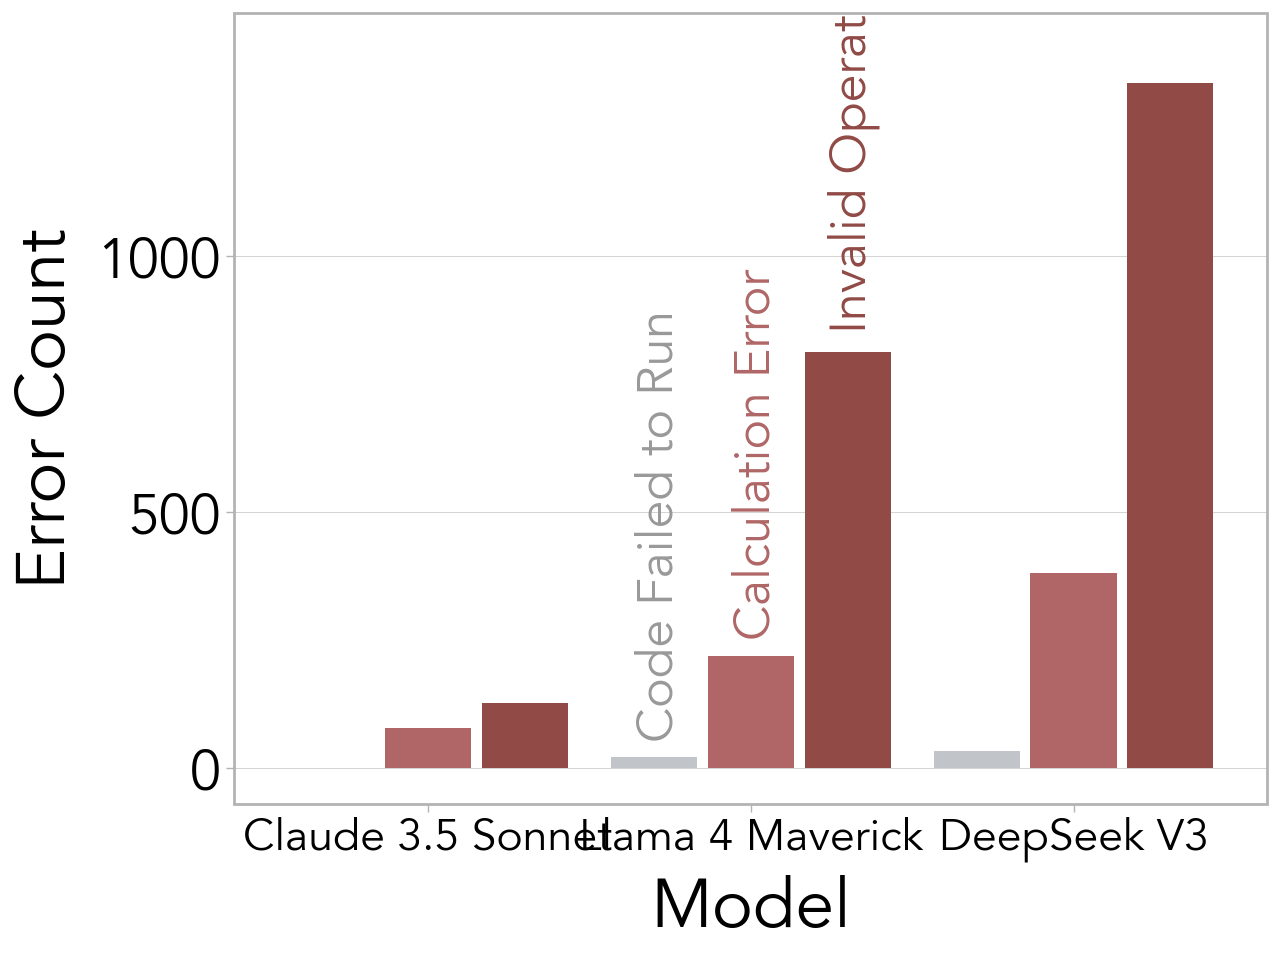

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.92 x 6 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/model_errors_by_type.png


In [14]:
# First, let's summarize the data by counting errors for each model and problem type
df_error_summary = (
    df_coder_errors_proc.groupby(["model", "problem_type"]).sum().reset_index()
)

# Calculate the maximum count for setting the y-limit with some margin for annotations
max_count = df_error_summary["count"].max()

# Assign colors to problem types - using the exact values from PROBLEM_TYPES

col_names = list(PROBLEM_TYPES.values())
problem_colors = {
    col_names[0]: RED_GRADIENT[-2],
    col_names[1]: RED_GRADIENT[-3],
    col_names[2]: COLOR_LIGHT,
}

df_error_summary["problem_type"] = pd.Categorical(
    df_error_summary["problem_type"],
    categories=list(PROBLEM_TYPES.values())[::-1],  # Reverse the order
    ordered=True,
)

# Set a specific order for models with Llama 4 Maverick in the middle
df_error_summary["model"] = pd.Categorical(
    df_error_summary["model"],
    categories=["Claude 3.5 Sonnet", "Llama 4 Maverick", "DeepSeek V3"],
    ordered=True,
)

# Create the grouped bar chart
error_plot = (
    ggplot(df_error_summary, aes(x="model", y="count", fill="problem_type"))
    + geom_bar(stat="identity", position=position_dodge(width=0.9), width=0.8)
    + scale_fill_manual(values=problem_colors)
    + scale_color_manual(values=problem_colors)
    + labs(
        x="Model",
        y="Error Count",
    )
    + GGPLOT_THEME
    + theme(
        legend_position="none",
        text=element_text(size=16),
        axis_text_x=element_text(size=16, angle=0, hjust=0.5),
        axis_text_y=element_text(size=20),
        axis_title_y=element_text(size=25),
        axis_title_x=element_text(size=25),
        panel_grid_major_y=element_line(color="#cccccc", size=0.3),
        panel_grid_major_x=element_blank(),
    )
    + coord_cartesian(ylim=(0, max_count * 1.05))  # Increased ylim for labels
)

# Update positions to match the new order of problem types
x_positions = [1.722, 2.022, 2.32]  # Reversed from before
y_positions = [50, 250, 850]  # Reversed from before
for i, problem_type in enumerate(
    list(PROBLEM_TYPES.values())[::-1]
):  # Not reversed here since we iterate in original order
    error_plot = error_plot + annotate(
        "text",
        x=x_positions[i],
        y=y_positions[i],
        label=problem_type,
        color=(
            problem_colors[problem_type]
            if problem_type != "Code Failed to Run"
            else "#999999"
        ),
        angle=90,
        size=18,
        ha="center",
        va="bottom",
    )

error_plot.show()
error_plot.save(
    here("figures/model_errors_by_type.png"),
    dpi=2000,
    width=SMALL_PANEL_WIDTH * 1.2,
    height=SMALL_PANEL_HEIGHT,
)

## 2. Characterize human planning


### 2.1 Characteristics of human search traces


#### Features of human graphs


##### Frequency of operations


length of df_features: 29682


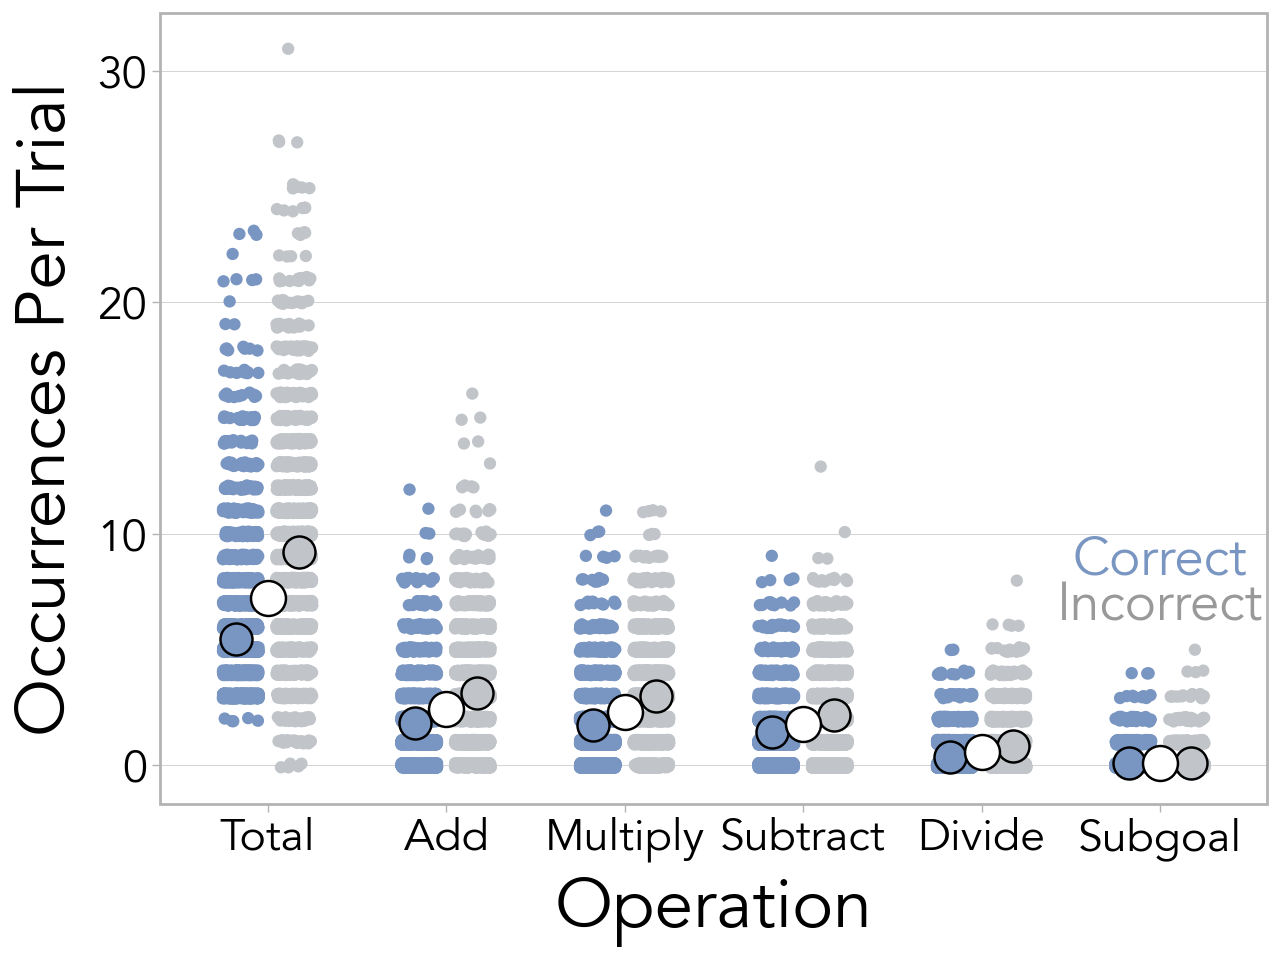

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.6000000000000005 x 6 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/operation_counts.png


In [15]:
# Calculate operation counts for each graph
operation_counts = df_coded_proc["graph"].apply(count_operations)

df_coded_proc["+_count"] = [oc["+"] for oc in operation_counts]
df_coded_proc["-_count"] = [oc["-"] for oc in operation_counts]
df_coded_proc["*_count"] = [oc["*"] for oc in operation_counts]
df_coded_proc["/_count"] = [oc["/"] for oc in operation_counts]

df_features = df_coded_proc[
    ["correct", "n_subgoals", "n_edges", "+_count", "-_count", "*_count", "/_count"]
]
# Melt the dataframe to create long format with metric and value columns
df_features = pd.melt(
    df_features, id_vars=["correct"], var_name="metric", value_name="value"
)

df_features["correct"] = df_features["correct"].map({1.0: "Correct", 0.0: "Incorrect"})

df_features["metric"] = df_features["metric"].map(
    {
        "n_edges": "Total",
        "+_count": "Add",
        "-_count": "Subtract",
        "*_count": "Multiply",
        "/_count": "Divide",
        "n_subgoals": "Subgoal",
    }
)

df_features["metric"] = pd.Categorical(
    df_features["metric"],
    categories=[
        "Total",
        "Add",
        "Multiply",
        "Subtract",
        "Divide",
        "Subgoal",
    ],
)

print(f"length of df_features: {len(df_features)}")

p = (
    ggplot(df_features, aes(x="metric", y="value", color="correct"))
    + geom_point(
        alpha=1,
        position=position_jitterdodge(
            dodge_width=0.6, jitter_width=0.2, jitter_height=0.1
        ),
        show_legend=False,
    )
    + stat_summary(
        fun_data="mean_cl_boot",
        geom="pointrange",
        position=position_dodge(width=0.7),
        color="black",
        size=1.5,
        mapping=aes(
            fill="correct",
            stroke=5,
        ),
        show_legend=False,  # Hide the fill legend
    )
    + GGPLOT_THEME
    # Add overall mean stat summary
    + stat_summary(
        fun_data="mean_cl_boot",
        geom="pointrange",
        color="black",
        fill="white",
        size=1.65,
        show_legend=True,
    )
    + labs(x="Operation", y="Occurrences Per Trial")
    + scale_color_manual(values=[COLOR_DARK, COLOR_LIGHT], guide=None)
    + scale_fill_manual(
        values=[COLOR_DARK, COLOR_LIGHT], guide=None
    )  # Remove fill guide
    + theme(legend_position="none", text=element_text(size=25))
    + theme(axis_text=element_text(size=16))
    + annotate(
        "text",
        x=6,
        y=8.8,
        label="Correct",
        color=COLOR_DARK,
        size=19,
    )
    + annotate(
        "text",
        x=6,
        y=6.8,
        label="Incorrect",
        color="#999999",
        size=19,
    )
)
p.show()
p.save(
    here("figures/operation_counts.png"),
    dpi=2000,
    width=SMALL_PANEL_WIDTH,
    height=SMALL_PANEL_HEIGHT,
)

##### Subgoal Groupings


n_subgoals
0    4502
1     356
2      62
3      20
4       6
5       1
Name: count, dtype: int64
number of trials with at least one subgoal:
445
total number of trials: 4947
proportion of trials with at least one subgoal:
0.0899535071760663


4947it [00:00, 58394.39it/s]


most common subgoal states:
(3, 8): 126
(4, 6): 112
(2, 12): 77
(12,): 22
(12, 12): 20
(11, 13): 20
(6,): 16
(8,): 11
(3,): 9
(10, 14): 9


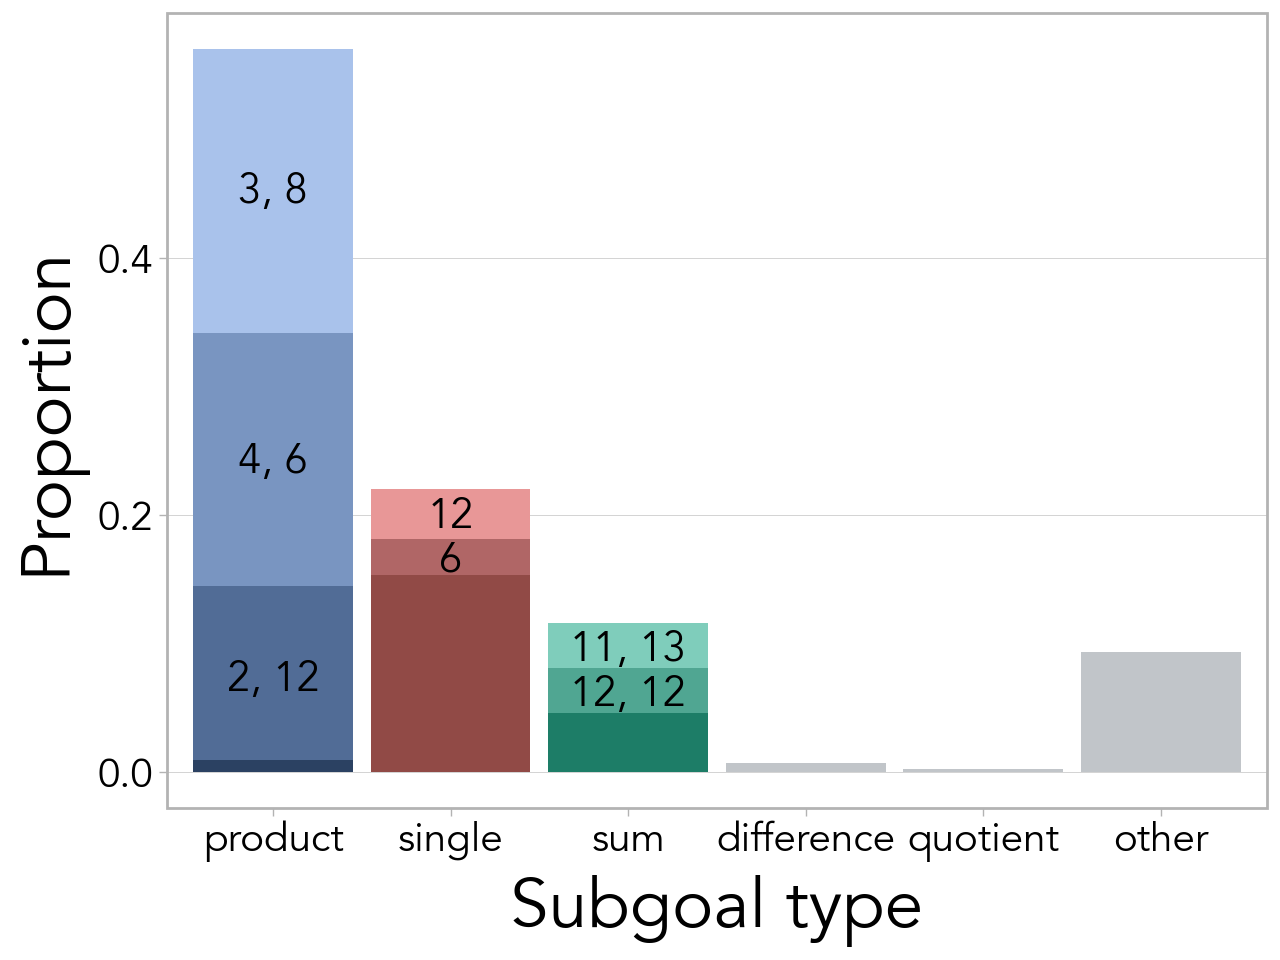

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.6000000000000005 x 6 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/subgoal_proportions.png


0.5785582255083179

In [16]:
print(df_coded_proc["n_subgoals"].value_counts())
print("number of trials with at least one subgoal:")
print(len(df_coded_proc[df_coded_proc["n_subgoals"] > 0]))
print(f"total number of trials: {len(df_coded_proc)}")
print("proportion of trials with at least one subgoal:")
print(len(df_coded_proc[df_coded_proc["n_subgoals"] > 0]) / len(df_coded_proc))
subgoal_state_counts = defaultdict(int)
all_subgoals = []
for _, row in tqdm(df_coded_proc.iterrows()):

    graph = row["graph"].G
    for edge in graph.edges():
        if graph.edges[edge]["operation"] == "subgoal":
            subgoal_state = edge[1]
            subgoal_state_counts[subgoal_state] += 1
            all_subgoals.append(subgoal_state)

df_subgoals = pd.DataFrame({"subgoal_state": all_subgoals})
df_subgoals["subgoal_state_type"] = df_subgoals["subgoal_state"].apply(
    classify_subgoal_state
)

df_subgoals["subgoal_state_type"] = pd.Categorical(
    df_subgoals["subgoal_state_type"],
    categories=["product", "single", "sum", "difference", "quotient", "other"],
    ordered=True,
)

df_subgoals = df_subgoals.sort_values(by="subgoal_state_type")

# first calculate counts for each subgoal state
df_subgoal_counts = df_subgoals["subgoal_state"].value_counts().reset_index()
df_subgoal_counts.columns = ["subgoal_state", "count"]

# create a mapping for colors
rare_states = set(df_subgoal_counts[df_subgoal_counts["count"] < 15]["subgoal_state"])

# create color list
dict_color_pallete = {
    "product": {
        (3, 8): "#a9c2eb",
        (4, 6): COLOR_DARK,
        (2, 12): "#516c96",
        "rare": COLOR_DARKER,
    },
    "single": {(12,): "#e89797", (6,): "#b06666", "rare": "#914a46"},
    "sum": {(11, 13): "#7fcdbb", (12, 12): "#50a692", "rare": "#1d7d67"},
    "difference": {"rare": COLOR_LIGHT},
    "quotient": {"rare": COLOR_LIGHT},
    "other": {"rare": COLOR_LIGHT},
}
# get all unique subgoal states and their types
unique_states = df_subgoals["subgoal_state"].unique()

colors = []
for state in unique_states:
    # find the state's subgoal_state_type
    state_type = classify_subgoal_state(state)
    if state in rare_states:
        color = dict_color_pallete[state_type]["rare"]
    else:
        color = dict_color_pallete[state_type][state]
    colors.append(color)
# calculate total count for proportions
total_count = len(df_subgoals)
df_subgoals["proportion"] = 1 / total_count

# sort subgoal states within each type by their counts
df_subgoals = df_subgoals.merge(df_subgoal_counts, on="subgoal_state")
df_subgoals = df_subgoals.sort_values(
    by=["subgoal_state_type", "count"], ascending=[True, False]
)

df_subgoals["subgoal_state_type"] = pd.Categorical(
    df_subgoals["subgoal_state_type"],
    categories=["product", "single", "sum", "difference", "quotient", "other"],
    ordered=True,
)

# create categorical subgoal_state with ordered levels based on counts
df_subgoals["subgoal_state"] = pd.Categorical(
    df_subgoals["subgoal_state"],
    categories=df_subgoals["subgoal_state"].unique(),
    ordered=True,
)

# print most common subgoals and their counts
print("\nmost common subgoal states:")
for _, row in df_subgoal_counts.head(10).iterrows():
    print(f"{row['subgoal_state']}: {row['count']}")


# modify the plot
p = (
    ggplot(df_subgoals, aes(x="subgoal_state_type", fill="subgoal_state"))
    + geom_bar(aes(y="proportion"), position="stack", stat="identity")
    + GGPLOT_THEME
    + labs(x="Subgoal type", y="Proportion")
    + annotate(
        "text",
        x="product",
        y=0.45,
        label="3, 8",
        size=15,
    )
    + annotate(
        "text",
        x="product",
        y=0.24,
        label="4, 6",
        size=15,
    )
    + annotate(
        "text",
        x="product",
        y=0.07,
        label="2, 12",
        size=15,
    )
    + annotate(
        "text",
        x="single",
        y=0.1975,
        label="12",
        size=15,
    )
    + annotate(
        "text",
        x="single",
        y=0.163,
        label="6",
        size=15,
    )
    + annotate(
        "text",
        x="sum",
        y=0.0935,
        label="11, 13",
        size=15,
    )
    + annotate(
        "text",
        x="sum",
        y=0.0585,
        label="12, 12",
        size=15,
    )
    + scale_fill_manual(values=dict(zip(unique_states, colors)))
    + theme(legend_position="none", text=element_text(size=25))
    # set size of axis labels
    + theme(axis_text=element_text(size=14.5))
)

p.show()
p.save(
    here("figures/subgoal_proportions.png"),
    width=SMALL_PANEL_WIDTH,
    height=SMALL_PANEL_HEIGHT,
    dpi=2000,
)

participants_with_at_least_one_subgoal = df_coded_proc[
    df_coded_proc["n_subgoals"] > 0
].pid.unique()
len(
    df_coded_proc[
        ~df_coded_proc["pid"].isin(participants_with_at_least_one_subgoal)
    ].pid.unique()
) / len(df_coded_proc.pid.unique())

In [17]:
# What proportion of subgoals are of each type?
df_subgoals["subgoal_state_type"].value_counts() / len(df_subgoals)

subgoal_state_type
product       0.562390
single        0.219684
sum           0.115993
other         0.093146
difference    0.007030
quotient      0.001757
Name: count, dtype: float64

#### Predictors of success and failure


##### Using subgoals


In [18]:
# plot proportion correct by number of subgoals
df_coded_proc["n_subgoals_binned"] = df_coded_proc["n_subgoals"].apply(
    lambda x: "0" if x == 0 else "1" if x == 1 else "2+"
)
(
    ggplot(df_coded_proc, aes(x="factor(n_subgoals_binned)", y="correct"))
    + stat_summary(fun_data="mean_cl_boot", geom="pointrange")
    + coord_cartesian(ylim=(0, 1))
    + labs(
        x="number of subgoals",
        y="proportion correct",
    )
    + scale_x_discrete(labels=["0", "1", "2+"])
    + theme_tufte()
).save(
    here("figures/performance_by_n_subgoals.png"),
    width=6,
    height=4,
    bbox_inches="tight",
    dpi=300,
)

print(df_coded_proc["n_subgoals_binned"].value_counts())

print("number of trials with at least one subgoal:")
print(len(df_coded_proc[df_coded_proc["n_subgoals_binned"] != "0"]))
print("number of trials in total:")
print(len(df_coded_proc))
print("proportion of trials with at least one subgoal:")
print(
    len(df_coded_proc[df_coded_proc["n_subgoals_binned"] != "0"]) / len(df_coded_proc)
)

# Calculate proportion correct for each category
proportions = df_coded_proc.groupby("n_subgoals_binned")["correct"].mean()
print("\nProportion correct by number of subgoals:")
for category, prop in proportions.items():
    print(f"{category}: {prop:.3f}")

# Perform permutation tests between all pairs
categories = ["0", "1", "2+"]
print("\nPermutation test results:")
for i, cat1 in enumerate(categories):
    for cat2 in categories[i + 1 :]:
        group1 = df_coded_proc[df_coded_proc["n_subgoals_binned"] == cat1]["correct"]
        group2 = df_coded_proc[df_coded_proc["n_subgoals_binned"] == cat2]["correct"]

        # run a permutation test
        res = stats.permutation_test(
            (group1, group2),
            statistic=lambda x, y, axis: np.mean(x, axis=axis) - np.mean(y, axis=axis),
            vectorized=True,
            n_resamples=10_000,
            permutation_type="independent",
        )

        print(f"{cat1} vs {cat2}:")
        print(f"  Difference: {res.statistic:.3f}")
        print(f"  p-value: {res.pvalue:.3f}")

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/performance_by_n_subgoals.png


n_subgoals_binned
0     4502
1      356
2+      89
Name: count, dtype: int64
number of trials with at least one subgoal:
445
number of trials in total:
4947
proportion of trials with at least one subgoal:
0.0899535071760663

Proportion correct by number of subgoals:
0: 0.527
1: 0.649
2+: 0.472

Permutation test results:
0 vs 1:
  Difference: -0.122
  p-value: 0.000
0 vs 2+:
  Difference: 0.055
  p-value: 0.347
1 vs 2+:
  Difference: 0.177
  p-value: 0.003


### 2.2 Consistency and variation in human search traces


#### Gini index analysis


example list of 2-grams: [('12+5=17', '17+5=22'), ('17+5=22', '12+12=24'), ('12+12=24', '24+5=29'), ('24+5=29', '29-5=24')]
199


/Users/ben/Documents/llm-verbal-protocol/src/analysis/gini_analysis.py:50: UserWarning: No operation found for timestep 4
/Users/ben/Documents/llm-verbal-protocol/src/analysis/gini_analysis.py:50: UserWarning: No operation found for timestep 12


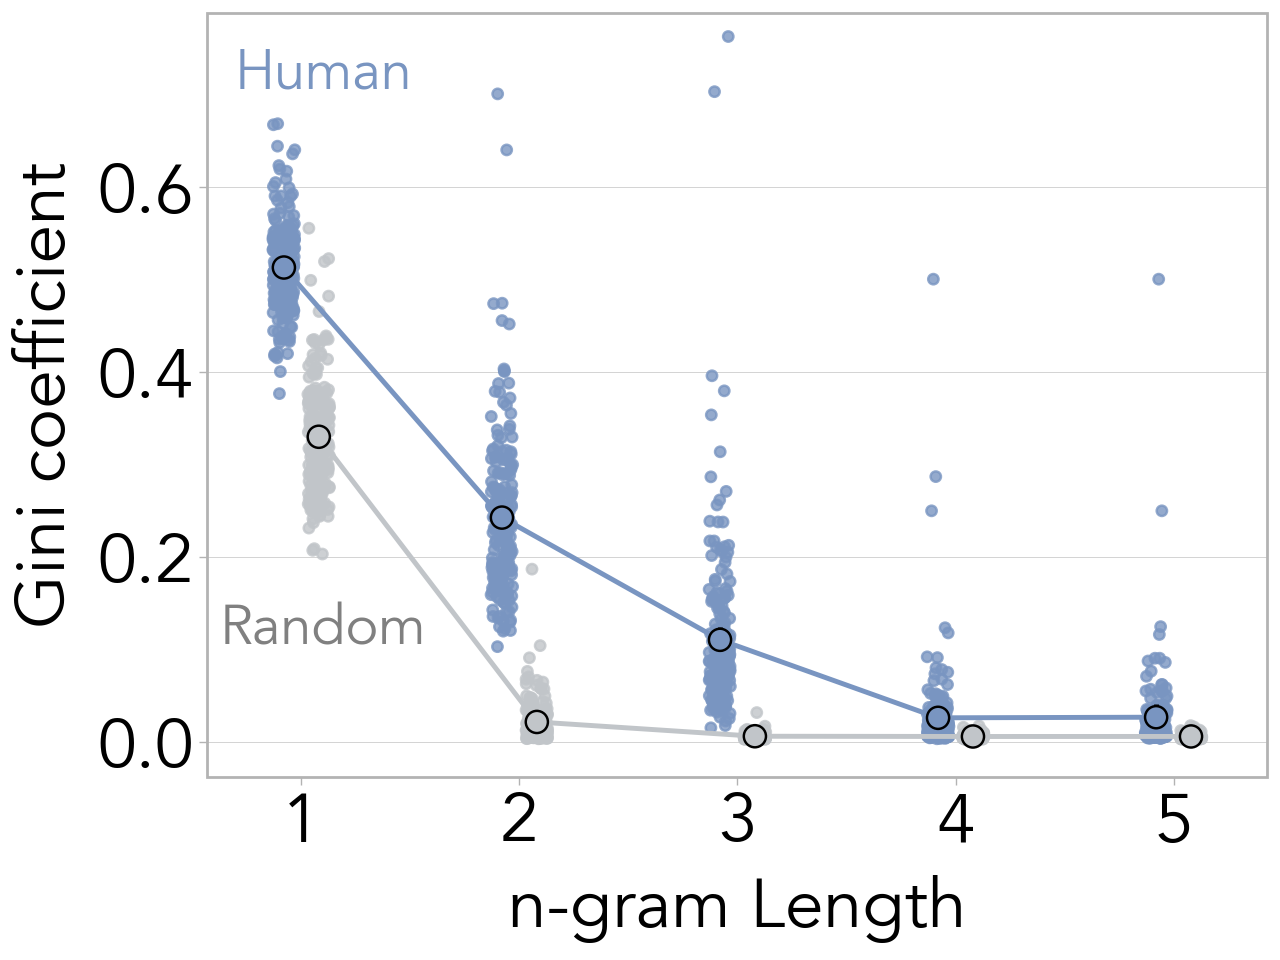

/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.6000000000000005 x 6 in image.
/Users/ben/mambaforge/envs/verbal-protocol-local/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /Users/ben/Documents/llm-verbal-protocol/figures/gini_by_ngram_length.png


In [19]:
df_coded_proc["operation_sequence"] = df_coded_proc["graph"].apply(
    lambda x: get_operation_sequence(x, include_subgoals=False)
)
for i in range(1, 6):
    df_coded_proc[f"op_{i}_grams"] = df_coded_proc["operation_sequence"].apply(
        lambda x: get_ngrams(x, i)
    )

print(f"example list of 2-grams: {df_coded_proc['op_2_grams'].iloc[0]}")

rows = []
print(len(df_coded_proc["choices"].drop_duplicates()))
for choices in df_coded_proc["choices"].drop_duplicates():
    # get all the ngrams in the choices
    df_trial = df_coded_proc[df_coded_proc["choices"] == choices]
    for i in range(1, 6):
        all_ngrams = []
        for op_ngrams in df_trial[f"op_{i}_grams"]:
            all_ngrams.extend(op_ngrams)
        gini = compute_gini(all_ngrams)
        rows.append({"trial": choices, "type": "human", "n": i, "gini": gini})

    all_human_ops = []
    for _, row in df_trial.iterrows():
        all_human_ops.extend(row["operation_sequence"])

    start_state = tuple(literal_eval(choices))
    legal_operations = list(set(all_human_ops))
    all_random_ops = []
    for _, row in df_trial.iterrows():
        all_random_ops.extend(
            get_random_op_sequence(
                start_state,
                row["n_edges"] - row["n_subgoals"],
            )
        )

    for i in range(1, 6):
        random_ngrams = get_ngrams(all_random_ops, i)
        random_gini = compute_gini(random_ngrams)
        rows.append({"trial": choices, "type": "random", "n": i, "gini": random_gini})

# Create a dataframe for plotting
plot_data = pd.DataFrame(rows)

# Create the plot
plot = (
    ggplot(plot_data, aes(x="n", y="gini", color="type"))
    + geom_point(
        alpha=0.8,
        position=position_jitterdodge(
            jitter_width=0.1, jitter_height=0.0, dodge_width=0.32
        ),
        size=1.6,
    )
    + stat_summary(
        fun_y=np.mean, geom="line", size=1, position=position_dodge(width=0.32)
    )
    + stat_summary(
        fun_data="mean_cl_boot",
        geom="pointrange",
        color="black",
        size=1,
        mapping=aes(fill="type"),
        position=position_dodge(width=0.32),
    )
    + coord_cartesian(ylim=(0, 0.75))
    + labs(
        x="n-gram Length",
        y="Gini coefficient",
    )
    + annotate(
        "text",
        x=1.1,
        y=0.72,
        label="Human",
        color=COLOR_DARK,
        size=20,
    )
    + annotate(
        "text",
        x=1.1,
        y=0.12,
        label="Random",
        color="grey",
        size=20,
    )
    + GGPLOT_THEME
    + scale_color_manual(values=[COLOR_DARK, COLOR_LIGHT])
    + scale_fill_manual(values=[COLOR_DARK, COLOR_LIGHT])
    + theme(
        legend_position="none",
        text=element_text(size=25),
    )
)

# show the plot
plot.show()
plot.save(
    here("figures/gini_by_ngram_length.png"),
    dpi=2000,
    width=SMALL_PANEL_WIDTH,
    height=SMALL_PANEL_HEIGHT,
)

#### Graph concentration visualization


[((2, 2, 3, 12), (2, 6, 12)), ((2, 2, 3, 12), (3, 4, 12)), ((2, 2, 3, 12), (1, 2, 12)), ((2, 2, 3, 12), (2, 3, 24)), ((2, 2, 3, 12), (-1, 2, 12)), ((2, 2, 3, 12), (2, 2, 4)), ((2, 2, 3, 12), (2, 2, 9)), ((2, 2, 3, 12), (2, 2, 36)), ((2, 6, 12), (12, 12)), ((2, 6, 12), (2, 18)), ((12, 12), (24,)), ((3, 4, 12), (12, 12)), ((1, 2, 12), (2, 12)), ((1, 2, 12), (1, 24)), ((2, 12), (24,)), ((2, 3, 24), (1, 24)), ((2, 3, 24), (2, 8)), ((1, 24), (24,)), ((2, 2, 4), (2, 8)), ((2, 8), (16,)), ((2, 2, 9), (2, 18))]


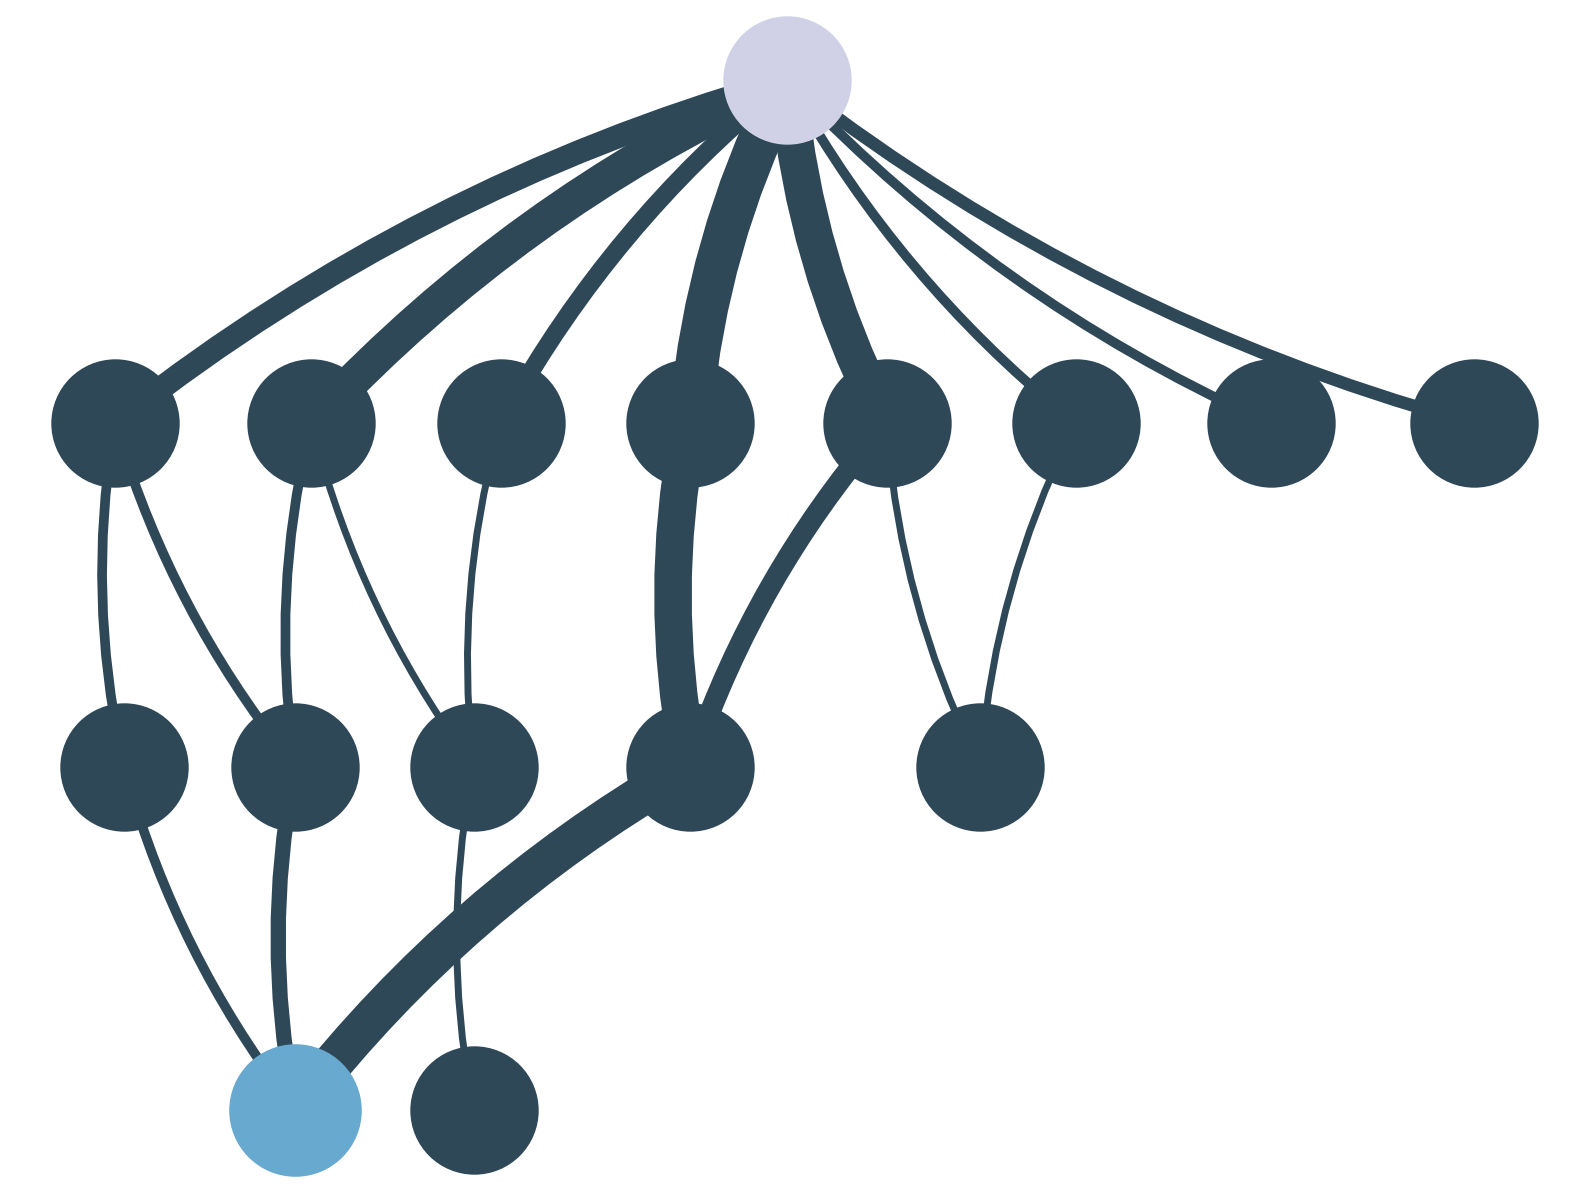

In [20]:
demonstration_problem = "[2,2,3,12]"

different_graph_colors = GRAPH_COLORS.copy()
different_graph_colors.update({"node_fill": "#F5F5F5"})

# Create deep copies of the graphs before uniting them
graphs_to_unite = [
    graph.copy()
    for graph in df_coded_proc.copy(deep=True).query(
        f"choices == '{demonstration_problem}'"
    )["graph"]
]
aggregated_graph = unite_graph_lst(
    graphs_to_unite, tuple(literal_eval(demonstration_problem))
)

pruned_graph = prune_graph(aggregated_graph, threshold=2)

fig, ax = pruned_graph.draw_graph(
    mode="aggregate", target=(24,), node_size=8000, colors=GRAPH_COLORS
)

# print edges in the pruned graph
print(pruned_graph.G.edges)
# tight layout
plt.tight_layout()
plt.savefig(here("figures/graph_clustering.svg"))
plt.show()
# erase the figure
plt.clf()

<Figure size 640x480 with 0 Axes>

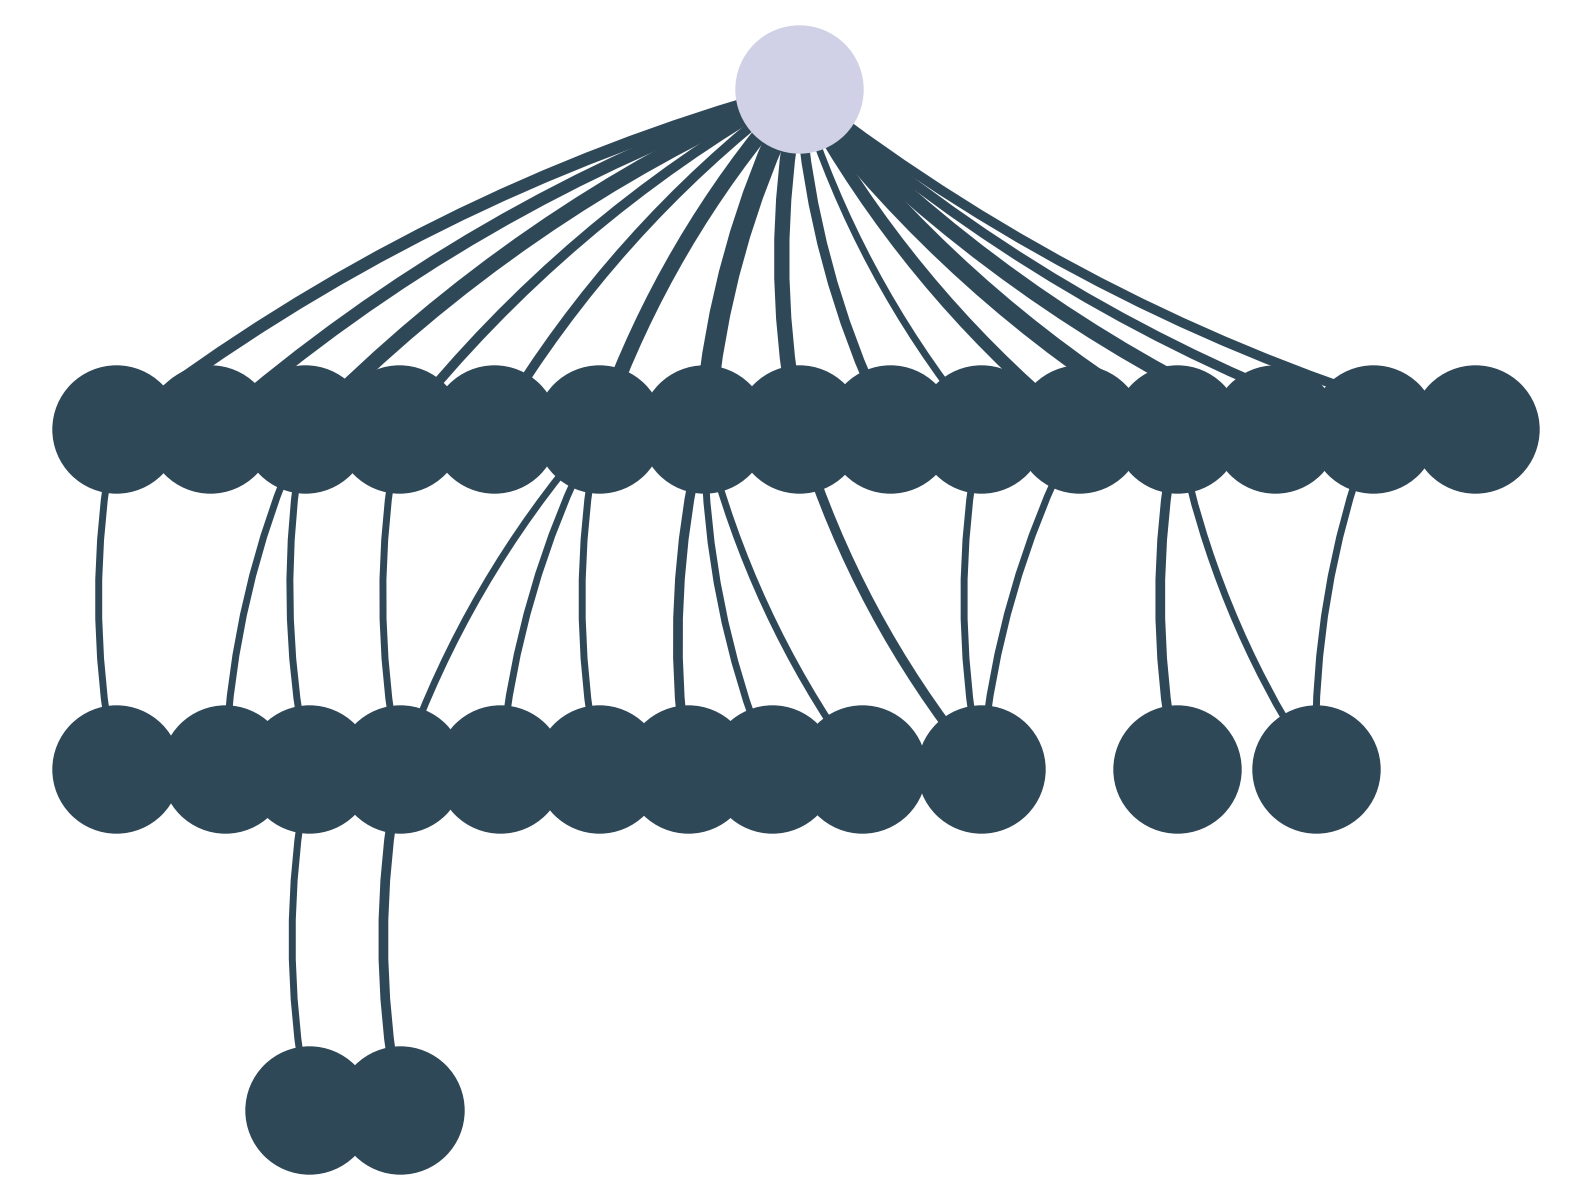

In [21]:
# Create deep copies of the graphs before uniting them
random_code_traces = sample_random_baseline_code_traces(
    start_state=demonstration_problem, df_participants=df_coded_proc
)
graphs = [run_code(code) for code in random_code_traces]
aggregated_graph = unite_graph_lst(graphs, tuple(literal_eval(demonstration_problem)))

pruned_graph = prune_graph(aggregated_graph, threshold=2)

fig, ax = pruned_graph.draw_graph(
    mode="aggregate", target=(24,), node_size=8000, colors=GRAPH_COLORS
)
# tight layout
plt.tight_layout()
plt.savefig(here("figures/graph_clustering_random_agent.svg"))
plt.show()
# erase the figure
plt.clf()

# Do people consider division when it's necessary?


In [22]:
df_problem_set["requires_division"] = df_problem_set.apply(requires_division, axis=1)
division_problems = df_problem_set[df_problem_set["requires_division"]][
    "Puzzles"
].tolist()

print(f"number of division problems: {len(division_problems)}")
division_problems = ["[" + p.replace(" ", ",") + "]" for p in division_problems]

df_coded_proc["requires_division"] = df_coded_proc["choices"].apply(
    lambda x: x in division_problems
)

print("Proportion correct by requiring division")

print(df_coded_proc.groupby("requires_division")["correct"].mean())

requires_division_correct = df_coded_proc[df_coded_proc["requires_division"]]["correct"]
requires_division_incorrect = df_coded_proc[~df_coded_proc["requires_division"]][
    "correct"
]

res = stats.permutation_test(
    (requires_division_correct, requires_division_incorrect),
    statistic=lambda x, y, axis: np.mean(x, axis=axis) - np.mean(y, axis=axis),
    vectorized=True,
    n_resamples=100_000,
    permutation_type="independent",
    random_state=rng,
)
print(f"p-value: {res.pvalue}")

df_coded_proc["division_count"] = df_coded_proc["graph"].apply(
    lambda x: count_divisions(x)
)
df_coded_proc["tried_division"] = df_coded_proc["division_count"].apply(lambda x: x > 0)

print(
    "got it wrong and tried division:",
    df_coded_proc[
        (df_coded_proc["requires_division"]) & (df_coded_proc["correct"] == 0)
    ]["tried_division"].mean(),
)

number of division problems: 29
Proportion correct by requiring division
requires_division
False    0.592707
True     0.198895
Name: correct, dtype: float64
p-value: 1.999980000199998e-05
got it wrong and tried division: 0.5275862068965518
